In [106]:
%pip install imblearn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [107]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
import optuna
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from tabulate import tabulate
import os
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [108]:
train=pd.read_csv('Train_data.csv\Train_data.csv')
test=pd.read_csv('Test_data.csv\Test_data.csv')
train


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0,tcp,exec,RSTO,0,0,0,0,0,0,...,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25188,0,tcp,ftp_data,SF,334,0,0,0,0,0,...,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00,anomaly
25189,0,tcp,private,REJ,0,0,0,0,0,0,...,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25190,0,tcp,nnsp,S0,0,0,0,0,0,0,...,20,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


In [109]:
train.info()
train.head()
train.describe()
train.describe(include='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

,protocol_type,service,flag,class
count,25192,25192,25192,25192
unique,3,66,11,2
top,tcp,http,SF,normal
freq,20526,8003,14973,13449


In [110]:
total = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")
    

In [111]:
df=train
df = pd.get_dummies(df, columns=['protocol_type'])

In [112]:
print(df.columns)

Index(['duration', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
       'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
       'num_compromised', 'root_shell', 'su_attempted', 'num_root',
       'num_file_creations', 'num_shells', 'num_access_files',
       'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
       'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
       'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_serror_rate', 'dst_host_srv_serror_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class',
       'protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp'],
      dtype='object')


In [113]:
df=train

In [114]:
print(df.dtypes)

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [115]:
for column in df.columns:
    if df[column].dtype == type(object):
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])

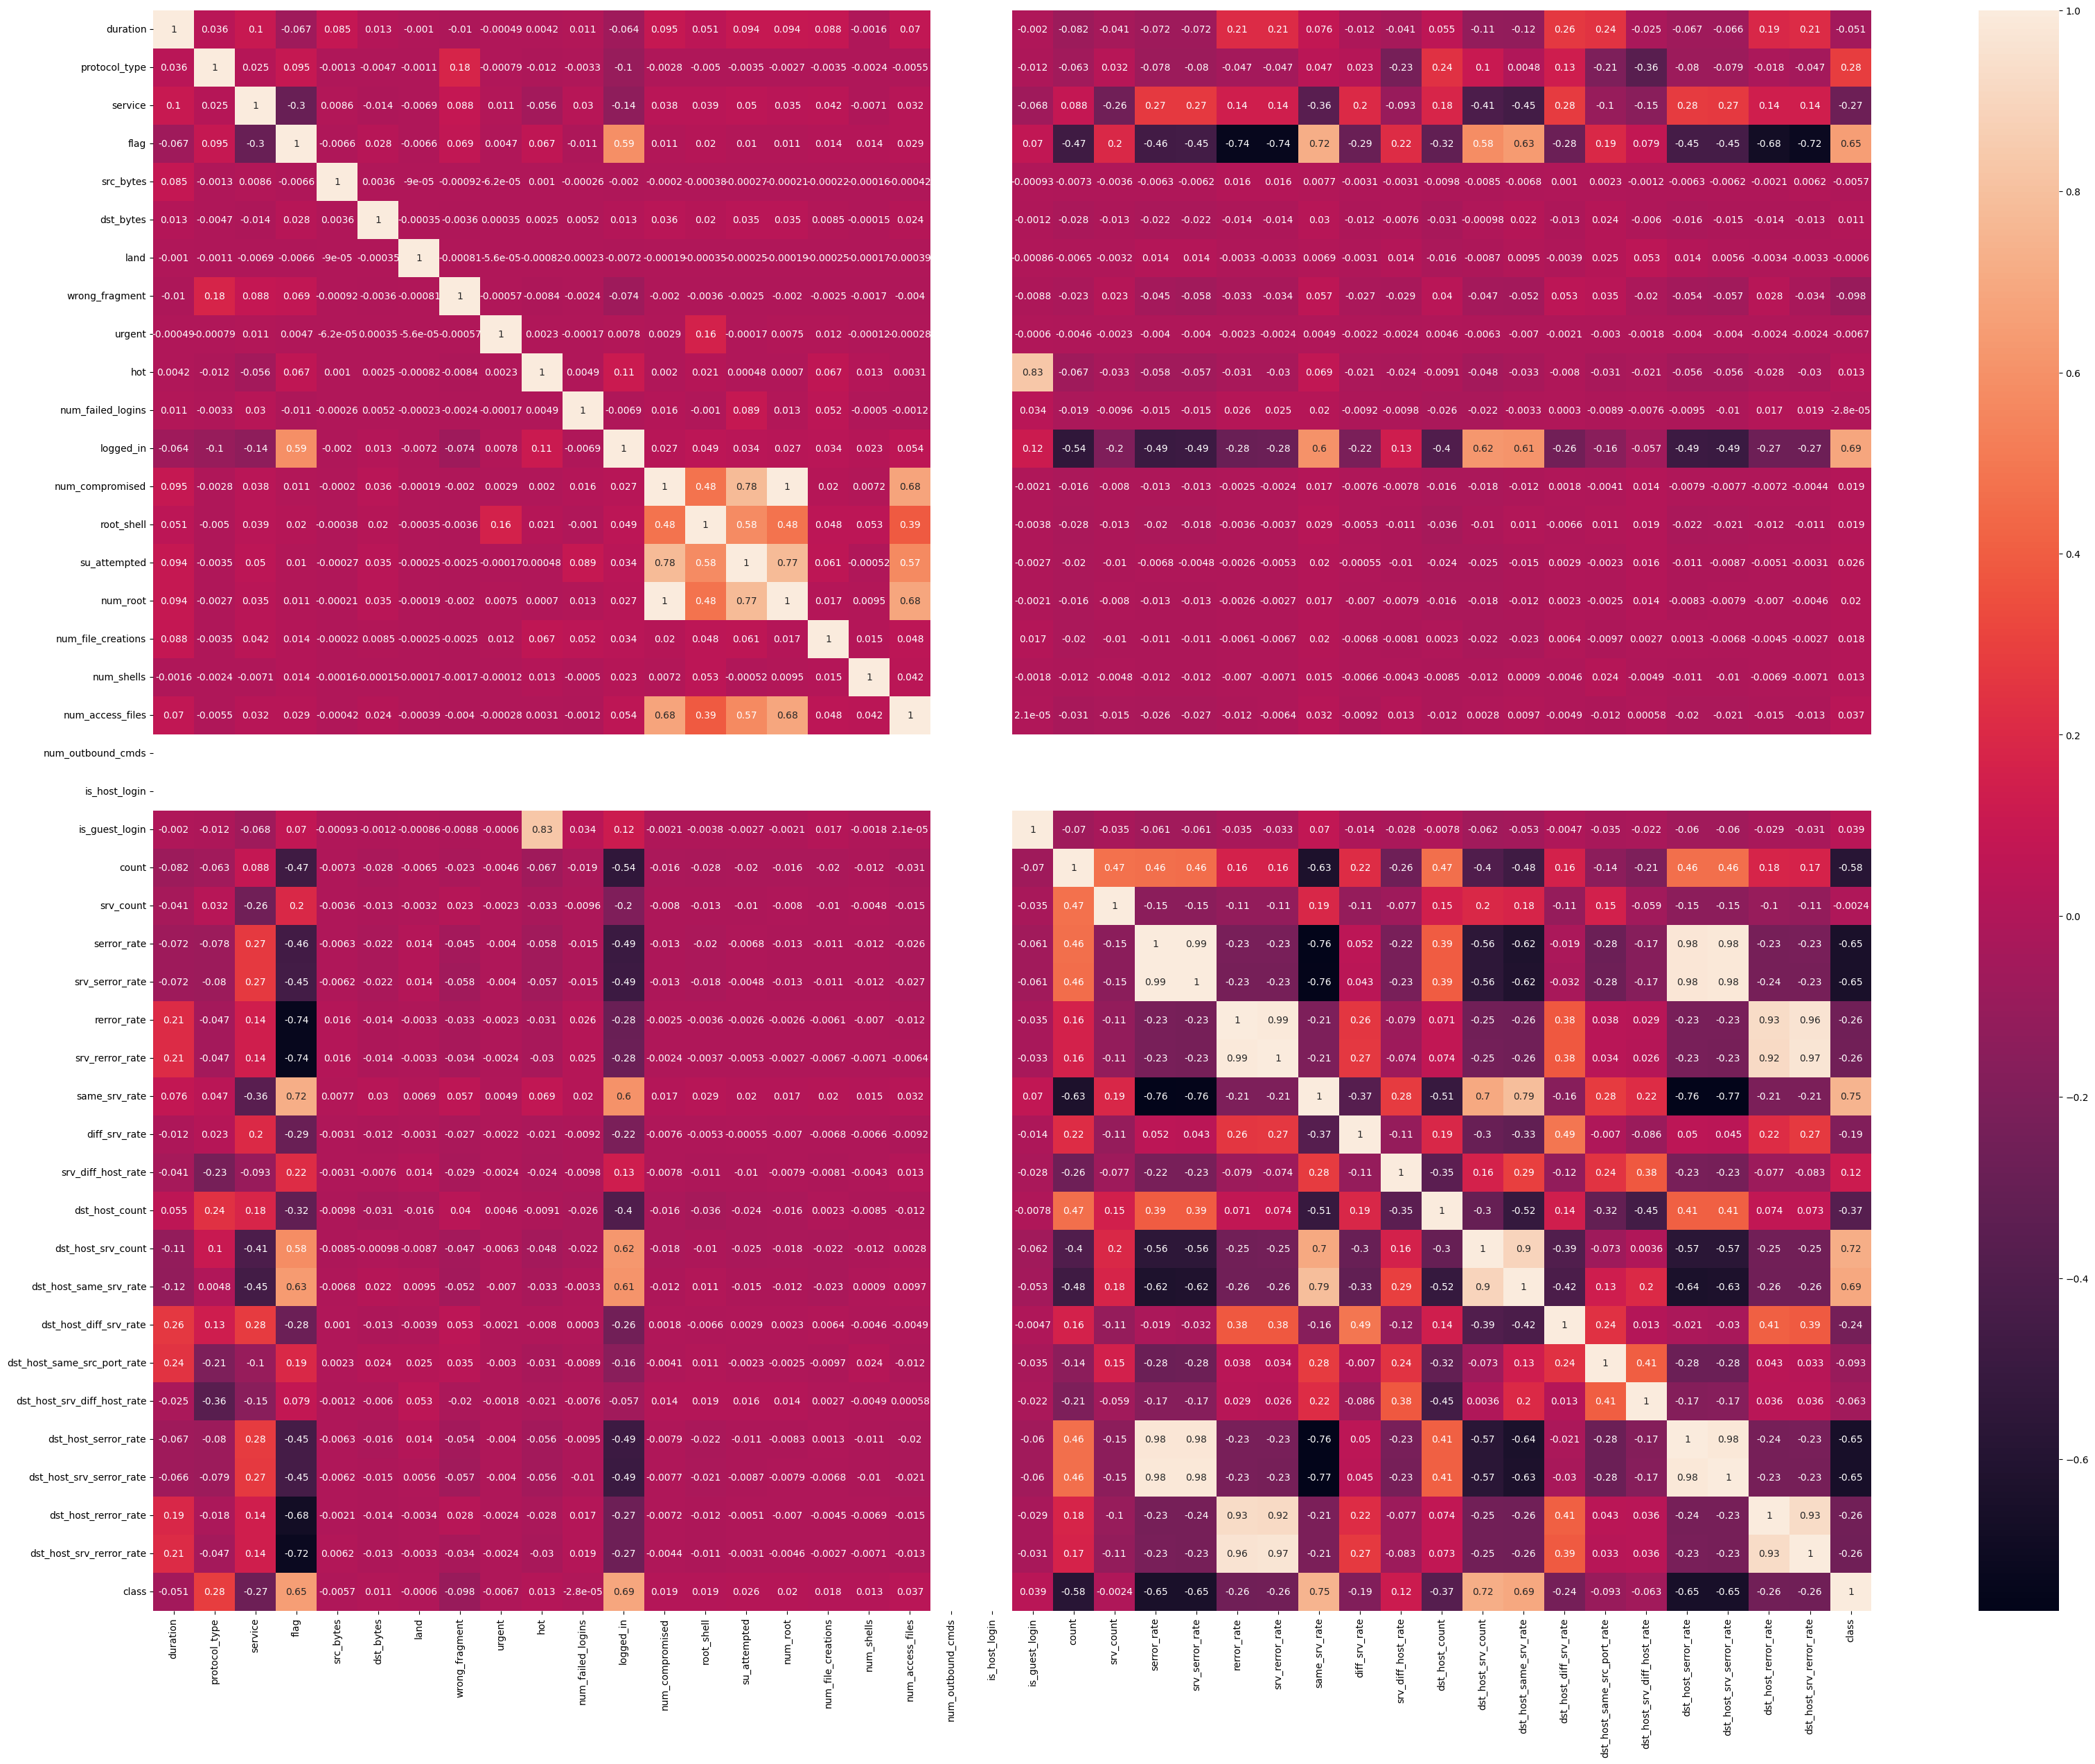

In [116]:
plt.figure(figsize=(40,30))
sns.heatmap(train.corr(), annot=True)

import plotly.express as px
fig = px.imshow(df.corr(), text_auto=True, aspect="auto")
fig.show()

<Axes: xlabel='class', ylabel='count'>

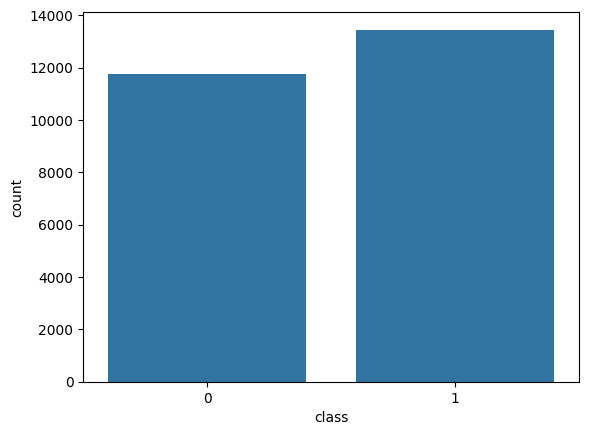

In [117]:
sns.countplot(x=train['class'])

In [118]:
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

le(train)
le(test)

In [119]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,19,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,41,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,46,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,22,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,22,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


In [120]:
X_train = train.drop(['class'], axis=1)
Y_train = train['class']

In [121]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate']

In [122]:
X_train = X_train[selected_features]

In [123]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test)

In [141]:
#y_train = y_train.to_numpy()


In [142]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

In [143]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [144]:
print(pd.isnull(X_train).any())
print(pd.isnull(y_train).any())

False
False


In [125]:
def objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x_train, y_train)
    y_pred = classifier_obj.predict(x_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    print(f"F1 Score = {f1score}")
    y_true=selected_features
    accuracy = accuracy_score(y_true, y_pred)
    #accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [126]:
print(len(X_train))  # Should print something like (number_of_samples, number_of_features)
print(len(y_train))   # Should print the number of samples

25192
17634


In [131]:
#X_reshaped = X_train.reshape(-1, 1)
#print(X_reshaped.shape)
#X_train, X_test, Y_train, Y_test = train_test_split(X_reshaped, Y, test_size=0.25, random_state=42)
#x_train, x_test, y_train, y_test = train_test_split(X_reshaped, Y_train, train_size=0.25, random_state=42)

(251920, 1)


ValueError: Found input variables with inconsistent numbers of samples: [251920, 25192]

In [ ]:
study_KNN = optuna.create_study(direction='maximize')
study_KNN.optimize(objective, n_trials=1)
print(study_KNN.best_trial)

[W 2024-01-24 11:08:44,410] Trial 0 failed with parameters: {'KNN_n_neighbors': 12} because of the following error: ValueError('Found input variables with inconsistent numbers of samples: [10, 7558]').
Traceback (most recent call last):
  File "c:\Users\91902\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\91902\AppData\Local\Temp\ipykernel_15636\4029118096.py", line 13, in objective
    accuracy = accuracy_score(y_true, y_pred)
  File "c:\Users\91902\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\91902\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py", line 220, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "c:\Users\91902\AppData\Local\Programs\Python\Python310\lib\site-pack

Precision = 0.9839506172839506
Recall = 0.9815270935960592
F1 Score = 0.9827373612823674


ValueError: Found input variables with inconsistent numbers of samples: [10, 7558]

In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(x_train, y_train)

KNN_train, KNN_test = KNN_model.score(x_train, y_train), KNN_model.score(x_test, y_test)

print(f"Train Score:{KNN_train}")
print(f"Test Score:{KNN_test}")

Train Score:0.9835544969944425
Test Score:0.9801534797565493


In [ ]:
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
xgb_train, xgb_test = xgb_model.score(x_train , y_train), xgb_model.score(x_test , y_test)

print(f"Training Score: {xgb_train}")
print(f"Test Score: {xgb_test}")

Training Score: 0.9999432913689463
Test Score: 0.9955014554114845
